# Customer Life time value by  Probabilistic CLV Models 
### using Lifetimes package
-   BG/NBD Model (Predicts future transaction frequency and churn rate)
-   GammaGamma Model

In [1]:
import pandas as pd 
import lifetimes as lf
from lifetimes.plotting import plot_probability_alive_matrix
import plotly.express as px

In [2]:
profit_margin=0.10 # 10% profit
df=pd.read_csv("./Dataset/Cleaned_Online_retail_dec2010-dec2011.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [3]:
df["InvoiceDate"]=pd.to_datetime(df["InvoiceDate"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397885 entries, 0 to 397884
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      397885 non-null  int64         
 1   StockCode    397885 non-null  object        
 2   Description  397885 non-null  object        
 3   Quantity     397885 non-null  int64         
 4   InvoiceDate  397885 non-null  datetime64[ns]
 5   Price        397885 non-null  float64       
 6   Customer ID  397885 non-null  int64         
 7   Country      397885 non-null  object        
 8   Revenue      397885 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 27.3+ MB


# BetaGeo/Negative Binomial Distribution (BG/NBD) Model
### Predicts the Buying and Churn Behaviour of customers using R,F,T
According to docs Penalizer is effective in range [0.0 ,0,1]

### Feature Engineering
 Lifetimes package can automatically produce Featues using its utils module
-   Frequency = No of purchases ( lf package counts as Number of  days Customer had a purchase (if F = 0 then only 1time))
-   Recency = How Recent a customer visited (if R = 0 then Most Recent)
-   T = Timespan of customer in days (from first purchase to last purchase)
-   Monetary value = Avg amount spend per transaction

In [4]:
Features=lf.utils.summary_data_from_transaction_data(
    df,
    customer_id_col="Customer ID",
    datetime_col="InvoiceDate",
    monetary_value_col="Revenue"
)
Features.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000


In [5]:
bgf=lf.BetaGeoFitter(penalizer_coef=0.0)

In [6]:
bgf.fit(frequency=Features["frequency"],recency=Features["recency"],T=Features["T"])

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.91, b: 6.75, r: 0.83>

In [7]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826542,0.026785,0.774044,0.879040
alpha,68.905121,2.611786,63.786020,74.024221
a,0.003437,0.010339,-0.016828,0.023702
b,6.745116,22.414725,-37.187745,50.677978


In [8]:
Features["Probability_alive"]=bgf.conditional_probability_alive(frequency=Features["frequency"],recency=Features["recency"],T=Features["T"])
Features["expected_purchases_in_90days"]=bgf.conditional_expected_number_of_purchases_up_to_time(t=90,frequency=Features["frequency"],recency=Features["recency"],T=Features["T"])
Features.head()

,frequency,recency,T,monetary_value,Probability_alive,expected_purchases_in_90days
Customer ID,,,,,,
12346,0.0,0.0,325.0,0.000000,1.000000,0.188830
12347,6.0,365.0,367.0,599.701667,0.999698,1.408736
12348,3.0,283.0,358.0,301.480000,0.999177,0.805907
12349,0.0,0.0,18.0,0.000000,1.000000,0.855607
12350,0.0,0.0,310.0,0.000000,1.000000,0.196304


<Axes: title={'center': 'Expected Number of Future Purchases for 90 Units of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

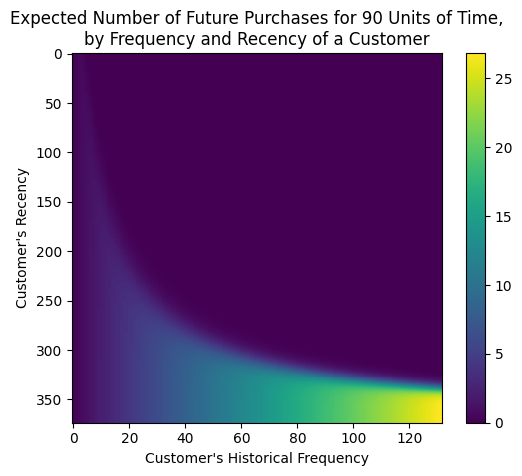

In [9]:
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions
plot_frequency_recency_matrix(bgf,T=90)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

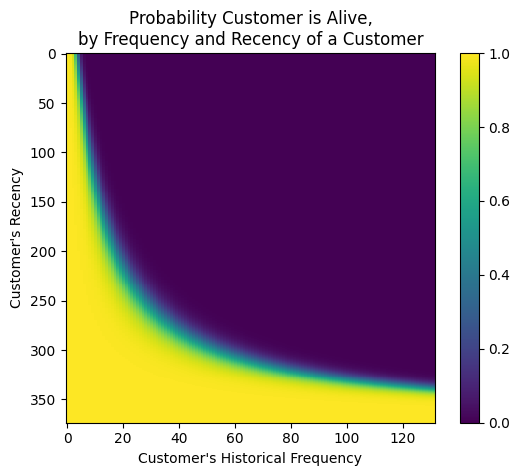

In [10]:
plot_probability_alive_matrix(bgf)

## Assesing Model fitness

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

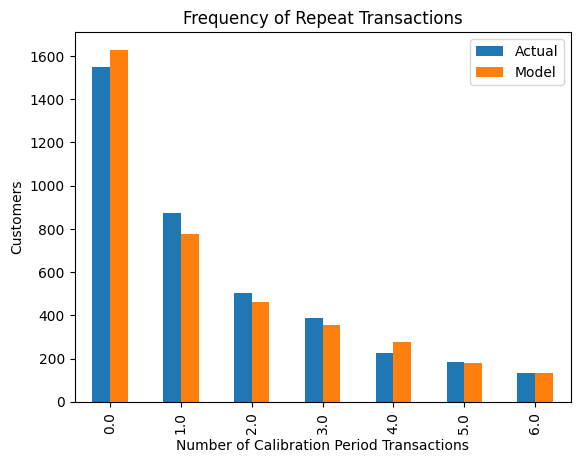

In [11]:
plot_period_transactions(bgf)

In [12]:
# Splitting data for training(6months) and testing(4months)
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
df_Cal_hold=calibration_and_holdout_data(df,
                                         customer_id_col="Customer ID",
                                         datetime_col="InvoiceDate",
                                         calibration_period_end="2011-09-01",
                                         observation_period_end="2011-12-31")
df_Cal_hold.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346,0.0,0.0,226.0,0.0,121.0
12347,4.0,238.0,268.0,2.0,121.0
12348,2.0,110.0,259.0,1.0,121.0
12350,0.0,0.0,211.0,0.0,121.0
12352,3.0,34.0,197.0,3.0,121.0


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

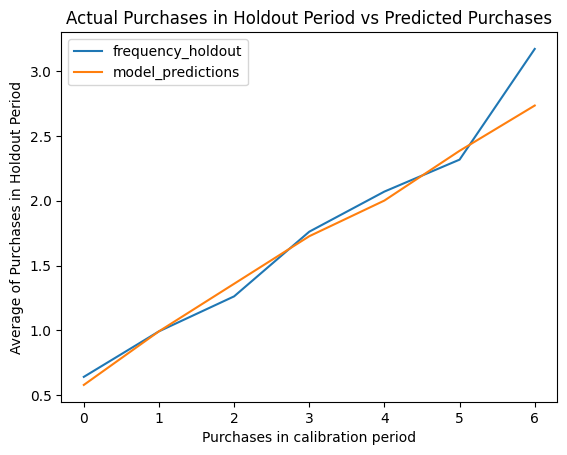

In [13]:
plot_calibration_purchases_vs_holdout_purchases(bgf,df_Cal_hold)

# GammaGamma Model
-   Predicts the CLV 
-   Assumes that Frequency & Monetary has Pearson Correaltion near to 0

In [14]:
Features=Features[Features["frequency"]>0]
Features.head()

,frequency,recency,T,monetary_value,Probability_alive,expected_purchases_in_90days
Customer ID,,,,,,
12347,6.0,365.0,367.0,599.701667,0.999698,1.408736
12348,3.0,283.0,358.0,301.480000,0.999177,0.805907
12352,6.0,260.0,296.0,368.256667,0.999406,1.682277
12356,2.0,303.0,325.0,269.905000,0.999478,0.645368
12358,1.0,149.0,150.0,683.200000,0.999486,0.750390


As Frquency = 0 means customers bought only once 

In [15]:
Features[Features["monetary_value"]<=0]

,frequency,recency,T,monetary_value,Probability_alive,expected_purchases_in_90days
Customer ID,,,,,,


In [16]:
Features[["frequency","monetary_value"]].corr()

,frequency,monetary_value
frequency,1.000000,0.015905
monetary_value,0.015905,1.000000


In [17]:
from lifetimes import GammaGammaFitter
ggf=GammaGammaFitter()

In [18]:
ggf.fit(frequency=Features["frequency"],monetary_value=Features["monetary_value"])
ggf

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.92>

In [19]:
Features["Expected_conditional_avg_revenue"]=ggf.conditional_expected_average_profit(frequency=Features["frequency"],monetary_value=Features["monetary_value"])

In [20]:
Features["Predict_CLV_3Months"]=ggf.customer_lifetime_value(bgf,
                                                            Features["frequency"],
                                                            Features["recency"],
                                                            Features["T"],
                                                            Features["monetary_value"],
                                                            time=3 ,  #in months
                                                            freq='D'  #frquency is in days
                                                            )

In [21]:
Features["Predict_CLV_Profit_3Months"]=Features["Predict_CLV_3Months"]*0.10  #10% profit margin
Features.head()

,frequency,recency,T,monetary_value,Probability_alive,expected_purchases_in_90days,Expected_conditional_avg_revenue,Predict_CLV_3Months,Predict_CLV_Profit_3Months
Customer ID,,,,,,,,,
12347,6.0,365.0,367.0,599.701667,0.999698,1.408736,569.977820,787.153453,78.715345
12348,3.0,283.0,358.0,301.480000,0.999177,0.805907,333.785887,263.709035,26.370904
12352,6.0,260.0,296.0,368.256667,0.999406,1.682277,376.175965,620.384166,62.038417
12356,2.0,303.0,325.0,269.905000,0.999478,0.645368,324.041778,205.012619,20.501262
12358,1.0,149.0,150.0,683.200000,0.999486,0.750390,539.904594,397.169912,39.716991


In [22]:
#Features.to_csv("./Outputs/Customers-BG-Gamama-Predictions-3months.csv")
#bgf.save_model("./Models/BgNbdModel-Purchase-Churn-behaviour.pickle")
#ggf.save_model("./Models/gammagammaModel-CLV-prediction.pickle")

In [23]:
print("Expected Conditional Avg Revenue : %s \n  Avg Profit : %s"%(
    Features["Expected_conditional_avg_revenue"].mean(),
    Features["monetary_value"].mean()
))

Expected Conditional Avg Revenue : 454.5955413501255 
  Avg Profit : 477.3824890515858


In [27]:
from plotly.offline import iplot,init_notebook_mode
init_notebook_mode(connected=True)

fig=px.histogram(Features["Predict_CLV_3Months"])
fig.update_layout(xaxis_title="",yaxis_title="",title={
            'text' : 'Predicted CLV in next 3Months (Histogram)',
            'x':0.5,
            'xanchor': 'center'
})
iplot(fig)